In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import pywt
def wavelet(data, level, wavelet):
    (cA, cD) = pywt.dwt(data, wavelet=wavelet)
    for i in range(1, level):
        (cA, cD) = pywt.dwt(cA, wavelet=wavelet)
    return cA, cD



In [3]:
gestures = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9
]
num_samples = 75
num_gestures = len(gestures)

one_hot = np.eye(len(gestures))



fulldata = pd.DataFrame(columns = ['aX','aY','aZ','gX','gY','gZ'])
fullwavedata = pd.DataFrame(columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'])
formatdata = pd.DataFrame()
formatwavedata = pd.DataFrame()

labels = []

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        filepath = 'Training data/test_{0}_{1}.csv'.format(gesture, i)
        data = pd.read_csv(filepath, index_col=False)
        wavedata = pd.DataFrame()
        
        level1 = 5
        wavetype1 = 'dmey'
        
        wavedata['aX_A1'], wavedata['aX_D1'] = wavelet(data['aX'], level=level1, wavelet=wavetype1)
        wavedata['aY_A1'], wavedata['aY_D1'] = wavelet(data['aY'], level=level1, wavelet=wavetype1)
        wavedata['aZ_A1'], wavedata['aZ_D1'] = wavelet(data['aZ'], level=level1, wavelet=wavetype1)

        wavedata['gX_A1'], wavedata['gX_D1'] = wavelet(data['gX'], level=level1, wavelet=wavetype1)
        wavedata['gY_A1'], wavedata['gY_D1'] = wavelet(data['gY'], level=level1, wavelet=wavetype1)
        wavedata['gZ_A1'], wavedata['gZ_D1'] = wavelet(data['gZ'], level=level1, wavelet=wavetype1)
        
        level2 = 2
        wavetype2 = 'rbio2.2'

        wavedata['aX_A2'], wavedata['aX_D2'] = wavelet(data['aX'], level=level2, wavelet=wavetype2)
        wavedata['aY_A2'], wavedata['aY_D2'] = wavelet(data['aY'], level=level2, wavelet=wavetype2)
        wavedata['aZ_A2'], wavedata['aZ_D2'] = wavelet(data['aZ'], level=level2, wavelet=wavetype2)

        wavedata['gX_A2'], wavedata['gX_D2'] = wavelet(data['gX'], level=level2, wavelet=wavetype2)
        wavedata['gY_A2'], wavedata['gY_D2'] = wavelet(data['gY'], level=level2, wavelet=wavetype2)
        wavedata['gZ_A2'], wavedata['gZ_D2'] = wavelet(data['gZ'], level=level2, wavelet=wavetype2)
        
        wavelen = len(wavedata)
        
        fullwavedata = fullwavedata.append(wavedata)
        fulldata = fulldata.append(data)
        label = gesture
        labels.append(label)
        del data, wavedata

labels = np.array(labels)


In [ ]:
normaldata = (fulldata - fulldata.min()) / (fulldata.max()-fulldata.min())
normaldata.describe()

In [ ]:
formatdata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, 76):#num_samples+1):
        
        index = idx*num_samples*250 + (i-1) * 250
        #print(index, index+250)
        dataf = normaldata.iloc[index:index+250].to_numpy().flatten().tolist()
        formatdata[idx*num_samples+i-1] = dataf
        del dataf
        
        
formatdata = formatdata.transpose().to_numpy()
formatdata


In [4]:
minval = np.array(fullwavedata.min(), dtype='float32')
maxval = np.array(fullwavedata.max(), dtype='float32')

In [5]:
parameters = pd.DataFrame([minval, maxval], columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'], index=['min','max'])
parameters.to_csv('dataparameters.csv')

In [6]:
normalwavedata = (fullwavedata - fullwavedata.min()) / (fullwavedata.max()-fullwavedata.min())
normalwavedata.describe()

,aX_A1,aX_D1,aY_A1,aY_D1,aZ_A1,aZ_D1,gX_A1,gX_D1,gY_A1,gY_D1,...,aY_A2,aY_D2,aZ_A2,aZ_D2,gX_A2,gX_D2,gY_A2,gY_D2,gZ_A2,gZ_D2
count,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,...,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000
mean,0.497516,0.467960,0.412851,0.517696,0.513952,0.523925,0.478586,0.520926,0.511014,0.537456,...,0.398164,0.381732,0.453108,0.721203,0.429104,0.492332,0.501349,0.482749,0.457911,0.566090
std,0.097294,0.060203,0.109414,0.083133,0.104303,0.090857,0.115142,0.074926,0.069332,0.062208,...,0.096932,0.028289,0.102511,0.026659,0.107746,0.035894,0.080755,0.029401,0.087218,0.032067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.437812,0.458941,0.329817,0.506758,0.476832,0.515462,0.441037,0.514579,0.488013,0.527616,...,0.327640,0.377211,0.421493,0.717386,0.406099,0.489741,0.484787,0.479179,0.441368,0.562537
50%,0.498379,0.467819,0.416661,0.517474,0.521585,0.525455,0.499227,0.521080,0.494951,0.537779,...,0.401008,0.381723,0.459248,0.721250,0.425846,0.492822,0.499732,0.482529,0.456847,0.566152
75%,0.553838,0.475911,0.484513,0.532906,0.548347,0.538299,0.514813,0.534569,0.520263,0.545159,...,0.456683,0.386304,0.482633,0.725293,0.445805,0.496821,0.511463,0.485648,0.471580,0.569730
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
formatwavedata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, 76):#num_samples+1):
        
        index = idx*num_samples*wavelen + (i-1) * wavelen
        #print(index, index+250)
        wavedataf = normalwavedata.iloc[index:index+wavelen].to_numpy().flatten().tolist()
        formatwavedata[idx*num_samples+i-1] = wavedataf
        del wavedataf
        
        
formatwavedata = formatwavedata.transpose().to_numpy()
formatwavedata 


array([[0.63299382, 0.47970438, 0.14634482, ..., 0.48133294, 0.45298797,
        0.56554193],
       [0.68543138, 0.42927659, 0.23015975, ..., 0.48546033, 0.43824259,
        0.56975438],
       [0.49537685, 0.44529983, 0.43293935, ..., 0.48927799, 0.45733925,
        0.55820254],
       ...,
       [0.48369692, 0.55754372, 0.39617257, ..., 0.48567272, 0.41288343,
        0.56390029],
       [0.63542805, 0.4983797 , 0.32888552, ..., 0.48247806, 0.42154822,
        0.56637728],
       [0.65150173, 0.45430185, 0.32573367, ..., 0.48076658, 0.46050967,
        0.56339774]])

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(formatwavedata, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15)
valsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15/0.85)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
for train_index, val_index in valsplit.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]

In [46]:
len(y_train)

524

In [9]:
for i in range(0,10):
    print('{3}: Train {0}; Test {1}; Val {2}'.format(np.size(np.where(y_train == i)) / len(y_train), np.size(np.where(y_test == i)) / len(y_test), np.size(np.where(y_val == i)) / len(y_val), i))

0: Train 0.10114503816793893; Test 0.09734513274336283; Val 0.09734513274336283
1: Train 0.09923664122137404; Test 0.10619469026548672; Val 0.09734513274336283
2: Train 0.09923664122137404; Test 0.09734513274336283; Val 0.10619469026548672
3: Train 0.10114503816793893; Test 0.09734513274336283; Val 0.09734513274336283
4: Train 0.09923664122137404; Test 0.10619469026548672; Val 0.09734513274336283
5: Train 0.09923664122137404; Test 0.09734513274336283; Val 0.10619469026548672
6: Train 0.09923664122137404; Test 0.10619469026548672; Val 0.09734513274336283
7: Train 0.09923664122137404; Test 0.09734513274336283; Val 0.10619469026548672
8: Train 0.10114503816793893; Test 0.09734513274336283; Val 0.09734513274336283
9: Train 0.10114503816793893; Test 0.09734513274336283; Val 0.09734513274336283


In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [60]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,

)
model.fit(X_train, y_train, 
            epochs=600,
            batch_size=32,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val))



Epoch 1/600
17/17 [==============================] - 1s 51ms/step - loss: 1.4642 - sparse_categorical_accuracy: 0.4905 - val_loss: 1.3093 - val_sparse_categorical_accuracy: 0.6106
Epoch 2/600
17/17 [==============================] - 1s 45ms/step - loss: 1.3503 - sparse_categorical_accuracy: 0.5878 - val_loss: 1.2088 - val_sparse_categorical_accuracy: 0.6549
Epoch 3/600
17/17 [==============================] - 1s 43ms/step - loss: 1.3118 - sparse_categorical_accuracy: 0.5725 - val_loss: 1.2001 - val_sparse_categorical_accuracy: 0.6460
Epoch 4/600
17/17 [==============================] - 1s 44ms/step - loss: 1.2684 - sparse_categorical_accuracy: 0.5802 - val_loss: 1.0996 - val_sparse_categorical_accuracy: 0.6460
Epoch 5/600
17/17 [==============================] - 1s 44ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.5954 - val_loss: 1.0063 - val_sparse_categorical_accuracy: 0.7522
Epoch 6/600
17/17 [==============================] - 1s 46ms/step - loss: 1.1613 - sparse_categorica

Epoch 46/600
17/17 [==============================] - 1s 42ms/step - loss: 0.4261 - sparse_categorical_accuracy: 0.8798 - val_loss: 0.3758 - val_sparse_categorical_accuracy: 0.8938
Epoch 47/600
17/17 [==============================] - 1s 42ms/step - loss: 0.4291 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.4867 - val_sparse_categorical_accuracy: 0.8407
Epoch 48/600
17/17 [==============================] - 1s 43ms/step - loss: 0.4709 - sparse_categorical_accuracy: 0.8397 - val_loss: 0.3700 - val_sparse_categorical_accuracy: 0.8938
Epoch 49/600
17/17 [==============================] - 1s 43ms/step - loss: 0.3891 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3823 - val_sparse_categorical_accuracy: 0.8850
Epoch 50/600
17/17 [==============================] - 1s 43ms/step - loss: 0.3894 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.3499 - val_sparse_categorical_accuracy: 0.8938
Epoch 51/600
17/17 [==============================] - 1s 45ms/step - loss: 0.4313 - sparse_cate

17/17 [==============================] - 1s 44ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.0961 - val_sparse_categorical_accuracy: 0.9735
Epoch 137/600
17/17 [==============================] - 1s 47ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0926 - val_sparse_categorical_accuracy: 0.9823
Epoch 138/600
17/17 [==============================] - 1s 59ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.1485 - val_sparse_categorical_accuracy: 0.9646
Epoch 139/600
17/17 [==============================] - 1s 52ms/step - loss: 0.1921 - sparse_categorical_accuracy: 0.9332 - val_loss: 0.1426 - val_sparse_categorical_accuracy: 0.9469
Epoch 140/600
17/17 [==============================] - 1s 59ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.1259 - val_sparse_categorical_accuracy: 0.9646
Epoch 141/600
17/17 [==============================] - 1s 54ms/step - loss: 0.1176 - sparse_categorical_

4/4 [==============================] - 0s 15ms/step - loss: 0.0242 - sparse_categorical_accuracy: 0.9912


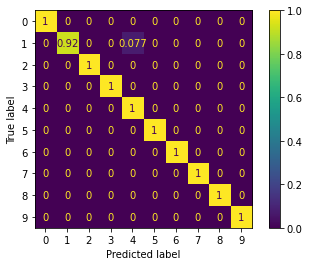

In [81]:
model.evaluate(X_test, y_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model.predict(X_test)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [83]:
#model = tf.keras.models.load_model('Training data/model1')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (Dense)                 (None, 1024)              1623040   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
result (Dense)               (None, 10)               

In [88]:
tf.saved_model.save(
    model, 'testvar')


INFO:tensorflow:Assets written to: testvar\assets


INFO:tensorflow:Assets written to: testvar\assets


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmppn6r4u0b\assets


In [13]:
interpreter = tf.lite.Interpreter(model_path='test_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)

[{'name': 'data_input', 'index': 0, 'shape': array([   1, 1584]), 'shape_signature': array([  -1, 1584]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [32]:
trydata = np.resize(X_test[0], (1, 1584))

TypeError: _resize_dispatcher() got an unexpected keyword argument 'dtype'

In [34]:
input_data = np.float32(np.resize(X_test[46], (1, 1584)))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(np.round(output_data, decimals=3))
print(y_test[46])

[[0.    0.004 0.    0.449 0.007 0.    0.    0.536 0.004 0.   ]]
7


In [26]:
for i in range(0, 113):
    input_data = np.float32(np.resize(X_test[i], (1, 1584)))
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data

    if np.max(output_data) < 0.6:
        print('Unsure')
        print(i)

Unsure
46


In [16]:
np.argmax(output_data)
if max(output_data) < 0.5:
    print()

1

In [12]:
interpreter = tf.lite.Interpreter(model_path='test_model.tflite')

signatures = interpreter.get_signature_list()
print(signatures)
predictor = interpreter.get_signature_runner()
print(predictor)



{}


ValueError: SignatureDef method_name is None and model has 0 Signatures. None is only allowed when the model has 1 SignatureDef

In [127]:
output = predictor(data_input=np.float32(X_test[0]))['result']
output

array([[1.0964601e-07, 9.1763778e-04, 1.6810007e-05, 4.2849658e-03,
        2.6555134e-03, 2.2810149e-05, 2.0116172e-04, 9.7670448e-01,
        4.2905535e-06, 1.5192278e-02]], dtype=float32)

In [128]:
X_test[0].size

1584

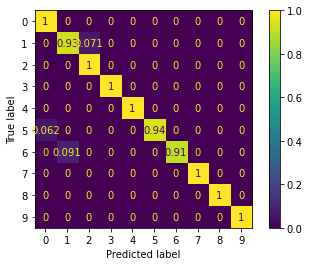

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

output_lbl = np.argmax(output, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, output_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Train model on full data

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers, callbacks

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
    )



testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val),
                    verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
  f.write(tflite_model)


Epoch 1/600
19/19 [==============================] - 2s 60ms/step - loss: 2.3390 - sparse_categorical_accuracy: 0.1017 - val_loss: 2.2305 - val_sparse_categorical_accuracy: 0.3628
Epoch 2/600
19/19 [==============================] - 1s 44ms/step - loss: 2.2527 - sparse_categorical_accuracy: 0.1700 - val_loss: 2.1536 - val_sparse_categorical_accuracy: 0.3097
Epoch 3/600
19/19 [==============================] - 1s 42ms/step - loss: 2.1669 - sparse_categorical_accuracy: 0.2367 - val_loss: 2.0661 - val_sparse_categorical_accuracy: 0.3451
Epoch 4/600
19/19 [==============================] - 1s 42ms/step - loss: 2.0874 - sparse_categorical_accuracy: 0.2733 - val_loss: 1.9300 - val_sparse_categorical_accuracy: 0.5929
Epoch 5/600
19/19 [==============================] - 1s 43ms/step - loss: 1.9522 - sparse_categorical_accuracy: 0.3600 - val_loss: 1.8719 - val_sparse_categorical_accuracy: 0.3451
Epoch 6/600
19/19 [==============================] - 1s 43ms/step - loss: 1.8894 - sparse_categorica

19/19 [==============================] - 1s 50ms/step - loss: 0.4006 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.5096 - val_sparse_categorical_accuracy: 0.8761
Epoch 47/600
19/19 [==============================] - 1s 46ms/step - loss: 0.4024 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8850
Epoch 48/600
19/19 [==============================] - 1s 42ms/step - loss: 0.4467 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.5863 - val_sparse_categorical_accuracy: 0.8496
Epoch 49/600
19/19 [==============================] - 1s 48ms/step - loss: 0.5388 - sparse_categorical_accuracy: 0.8217 - val_loss: 0.4825 - val_sparse_categorical_accuracy: 0.8761
Epoch 50/600
19/19 [==============================] - 1s 46ms/step - loss: 0.4291 - sparse_categorical_accuracy: 0.8683 - val_loss: 0.4567 - val_sparse_categorical_accuracy: 0.8673
Epoch 51/600
19/19 [==============================] - 1s 47ms/step - loss: 0.4671 - sparse_categorical_accur

19/19 [==============================] - 1s 49ms/step - loss: 0.1583 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.3676 - val_sparse_categorical_accuracy: 0.8850
Epoch 92/600
19/19 [==============================] - 1s 46ms/step - loss: 0.1842 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9292
Epoch 93/600
19/19 [==============================] - 1s 41ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.3185 - val_sparse_categorical_accuracy: 0.9115
Epoch 94/600
19/19 [==============================] - 1s 45ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.3369 - val_sparse_categorical_accuracy: 0.9292
Epoch 95/600
19/19 [==============================] - 1s 44ms/step - loss: 0.1979 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.3734 - val_sparse_categorical_accuracy: 0.9204
Epoch 96/600
19/19 [==============================] - 1s 42ms/step - loss: 0.2433 - sparse_categorical_accur

19/19 [==============================] - 1s 43ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.2822 - val_sparse_categorical_accuracy: 0.9469
Epoch 137/600
19/19 [==============================] - 1s 42ms/step - loss: 0.0716 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.2090 - val_sparse_categorical_accuracy: 0.9381
Epoch 138/600
19/19 [==============================] - 1s 43ms/step - loss: 0.1360 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.3553 - val_sparse_categorical_accuracy: 0.9027
Epoch 139/600
19/19 [==============================] - 1s 44ms/step - loss: 0.1385 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.3011 - val_sparse_categorical_accuracy: 0.9292
Epoch 140/600
19/19 [==============================] - 1s 43ms/step - loss: 0.1209 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.3064 - val_sparse_categorical_accuracy: 0.9204
Epoch 141/600
19/19 [==============================] - 1s 44ms/step - loss: 0.1399 - sparse_categorical_

19/19 [==============================] - 1s 44ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.2463 - val_sparse_categorical_accuracy: 0.9469
Epoch 182/600
19/19 [==============================] - 1s 45ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.9558
Epoch 183/600
19/19 [==============================] - 1s 43ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.2209 - val_sparse_categorical_accuracy: 0.9469
Epoch 184/600
19/19 [==============================] - 1s 42ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.2051 - val_sparse_categorical_accuracy: 0.9558
Epoch 185/600
19/19 [==============================] - 1s 47ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.2181 - val_sparse_categorical_accuracy: 0.9558
Epoch 186/600
19/19 [==============================] - 1s 45ms/step - loss: 0.0498 - sparse_categorical_

## Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

hyperparameters = pd.DataFrame()
for s in range(6,12):
    for n in range(4, 10):
        validation = []
        for i in range(1,11):       
            
            model = None
            opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(2**s, activation='relu')) # relu is used for performance
            model.add(tf.keras.layers.Dense(2**s, activation='relu'))
            model.add(tf.keras.layers.Dense(2**s, activation='relu'))
            model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
            model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001, # minimium amount of change to count as an improvement
                patience=25, # how many epochs to wait before stopping
                restore_best_weights=True,
            )

            X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

            model.fit(X_train, y_train, 
                                epochs=600,
                                batch_size=2**n,
                                callbacks=[early_stopping],
                                validation_data=(X_val, y_val),
                                verbose=0)
            
            validation.append(model.evaluate(X_test, y_test, verbose=0))
            
        indexing = 'size={0},bs={1}'.format(2**s,2**n)
        hyperparameters[indexing] = np.average(validation, axis=0)
        print(indexing)
        hyperparameters.transpose().to_csv('Training data/Search results.csv') 

  
hyperparameters

In [ ]:
hyperparameters